In [12]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy.io as sio
from process_behavior_and_movement_data import SessionDataProcessor
from analyze_behavior_data_functions import BehaviorDataAnalyzer, MovementAnalyzer
import matplotlib as mpl
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Remove right and top spines from plots (personal preference)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [18]:
# Initialize the analyzers
behavior_analyzer = BehaviorDataAnalyzer(base_dir='/Users/akhilbandi/Library/Mobile Documents/com~apple~CloudDocs/Documents/Portfolio/classes/project/kinematic data/')
movement_analyzer = MovementAnalyzer()

In [19]:
figures_dir = "figures"
data_dir = 'dynamic_choice'

# Load Data

In [20]:
mouse_list = ['IS-2-1L']

date_lists = {
    'IS-2-1L': ['250314', '250320', '250401', '250402', '250404', '250408'],  
}

#date_lists = {
#    'IS-2-1L': ['250401', '250402', '250404', '250408'],  
#}

In [22]:
# Initialize dictionaries to store results
all_task_dfs = {}
all_trialized_data = {}

# Load data for each mouse and date
for mouse in mouse_list:
    #print(f"\nLoading data for mouse {mouse}")
    mouse_task_dfs = []
    mouse_trialized_data = []
    
    for date in date_lists[mouse]:
        try:
            #print(f"\nAttempting to load date: {date}")
            task_df, trialized_data = behavior_analyzer.load_session_data(
                mouse_name=mouse,
                date=date,
                verbose=False
            )
            
            # Add date identifier to task_df
            task_df['date'] = date
            
            # Filter out trials that are within 5 trials after a context switch
            filtered_task_df = task_df.copy()
            context_changes = filtered_task_df['context'].diff().ne(0)
            
            # Create a counter that resets at each context change
            trials_since_change = np.zeros(len(filtered_task_df))
            counter = 0
            for i in range(len(filtered_task_df)):
                if context_changes.iloc[i]:
                    counter = 0
                trials_since_change[i] = counter
                counter += 1
            
            filtered_task_df['trials_since_change'] = trials_since_change
            
            # Keep only trials that are at least 5 trials after a context switch
            filtered_task_df = filtered_task_df[filtered_task_df['trials_since_change'] >= 0]
            
            # Store results for this date
            mouse_task_dfs.append(filtered_task_df)
            mouse_trialized_data.append(trialized_data)
            
            # Print session info
            #print(f"Successfully loaded {len(task_df)} trials")
            #print(f"Performance: {task_df['outcome'].mean():.1%}")
            
        except Exception as e:
            print(f"Error loading data for date {date}: {str(e)}")
            continue
    
    if mouse_task_dfs:  # Only store if we successfully loaded any sessions
        # Combine all sessions for this mouse
        all_task_dfs[mouse] = pd.concat(mouse_task_dfs, ignore_index=True)
        
        # Store trialized data as a list of sessions
        all_trialized_data[mouse] = mouse_trialized_data
        
        # Print summary for this mouse
        print(f"\nSummary for mouse {mouse}:")
        print(f"Total sessions: {len(mouse_task_dfs)}")
        print(f"Total trials: {len(all_task_dfs[mouse])}")
        print(f"Overall performance: {all_task_dfs[mouse]['outcome'].mean():.1%}")

Found 0 Cell files and 0 Data files
Error loading data for date 250314: No matching files found for CBIS-2-1L_250314
Found 0 Cell files and 0 Data files
Error loading data for date 250320: No matching files found for CBIS-2-1L_250320
Found 0 Cell files and 0 Data files
Error loading data for date 250401: No matching files found for CBIS-2-1L_250401
Found 1 Cell files and 1 Data files
Loading Cell file: /Users/akhilbandi/Library/Mobile Documents/com~apple~CloudDocs/Documents/Portfolio/classes/project/kinematic data/CBIS-2-1L/CBIS-2-1L_250402_Cell.mat
Loading Data file: /Users/akhilbandi/Library/Mobile Documents/com~apple~CloudDocs/Documents/Portfolio/classes/project/kinematic data/CBIS-2-1L/CBIS-2-1L_250402.mat

First trial structure:
Available fields: ('info', 'result', 'time', 'maze')
Found 283 trial starts and 282 trial stops
Found 1 Cell files and 1 Data files
Loading Cell file: /Users/akhilbandi/Library/Mobile Documents/com~apple~CloudDocs/Documents/Portfolio/classes/project/kinema

In [23]:
all_task_dfs['IS-2-1L']

trial_num  choice  condition task_type  visual_stim  audio_stim  context  \
0            0       0          1       avc          0.0         0.0        0   
1            1       1          2       avc         90.0         1.0        0   
2            2       0          1       avc          0.0         0.0        0   
3            3       1          2       avc         90.0         1.0        0   
4            4       0          1       avc          0.0         0.0        0   
..         ...     ...        ...       ...          ...         ...      ...   
947        336       1          2       avc         90.0         1.0        0   
948        337       1          2       avc         90.0         1.0        0   
949        338       1          2       avc         90.0         1.0        0   
950        339       0          1       avc          0.0         0.0        0   
951        340       1          2       avc         90.0         1.0        0   

     outcome  opto    date      mouse  trials_since_change  
0          1     0  250402  CBIS-2-1L                  0.0  
1          1     0  250402  CBIS-2-1L                  1.0  
2          1     0  250402  CBIS-2-1L                  2.0  
3          1     0  250402  CBIS-2-1L                  3.0  
4          1     0  250402  CBIS-2-1L                  4.0  
..       ...   ...     ...        ...                  ...  
947        1     0  250408  CBIS-2-1L                 49.0  
948        1     0  250408  CBIS-2-1L                 50.0  
949        1     0  250408  CBIS-2-1L                 51.0  
950        1     0  250408  CBIS-2-1L                 52.0  
951        1     0  250408  CBIS-2-1L                 53.0  

[952 rows x 12 columns]

### Task Accuracy Across Contexts

In [7]:
def plot_context_accuracy_with_sessions(task_df):
    """
    Plot mean accuracy across contexts with individual session averages connected by lines.
    
    Args:
        task_df (pd.DataFrame): DataFrame containing trial information for one mouse
        
    Returns:
        tuple: (fig, ax) matplotlib figure and axes objects
    """
    fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=800)
    
    context_names = ['Congruent', 'Visual', 'Audio']
    context_colors = {0: 'purple', 1: '#EC008C', 2: '#27AAE1'}
    
    # Calculate overall means and SEMs for each context
    means = []
    sems = []
    for ctx in [0, 1, 2]:
        ctx_trials = task_df[task_df['context'] == ctx]
        mean_acc = ctx_trials['outcome'].mean() * 100
        sem_acc = scipy.stats.sem(ctx_trials['outcome']) * 100
        means.append(mean_acc)
        sems.append(sem_acc)
    
    # Plot overall means with error bars
    x_positions = np.arange(len(context_names))
    ax.bar(x_positions, means, 
           color=[context_colors[i] for i in range(3)],
           alpha=0.7)
    #ax.errorbar(x_positions, means, yerr=sems,
    #           fmt='none', color='black', capsize=5)
    
    # Plot individual session data and connect them
    for session_date in task_df['date'].unique():
        session_df = task_df[task_df['date'] == session_date]
        session_means = []
        
        # Calculate mean for each context in this session
        for ctx in [0, 1, 2]:
            ctx_trials = session_df[session_df['context'] == ctx]
            if len(ctx_trials) > 0:
                session_means.append(ctx_trials['outcome'].mean() * 100)
            else:
                session_means.append(np.nan)
        
        # Plot points and connecting lines
        ax.plot(x_positions, session_means, 
                color='gray', alpha=0.3, linewidth=0.5)
        
        # Plot individual points
        for ctx in [0, 1, 2]:
            if not np.isnan(session_means[ctx]):
                ax.scatter(x_positions[ctx], session_means[ctx],
                          color=context_colors[ctx],
                          s=30, alpha=0.7,
                          edgecolor='white', linewidth=0.5)
    
    # Customize plot
    ax.set_xticks(x_positions)
    ax.set_xticklabels(context_names)
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim(40, 100)
    
    # Add chance line
    ax.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig, ax

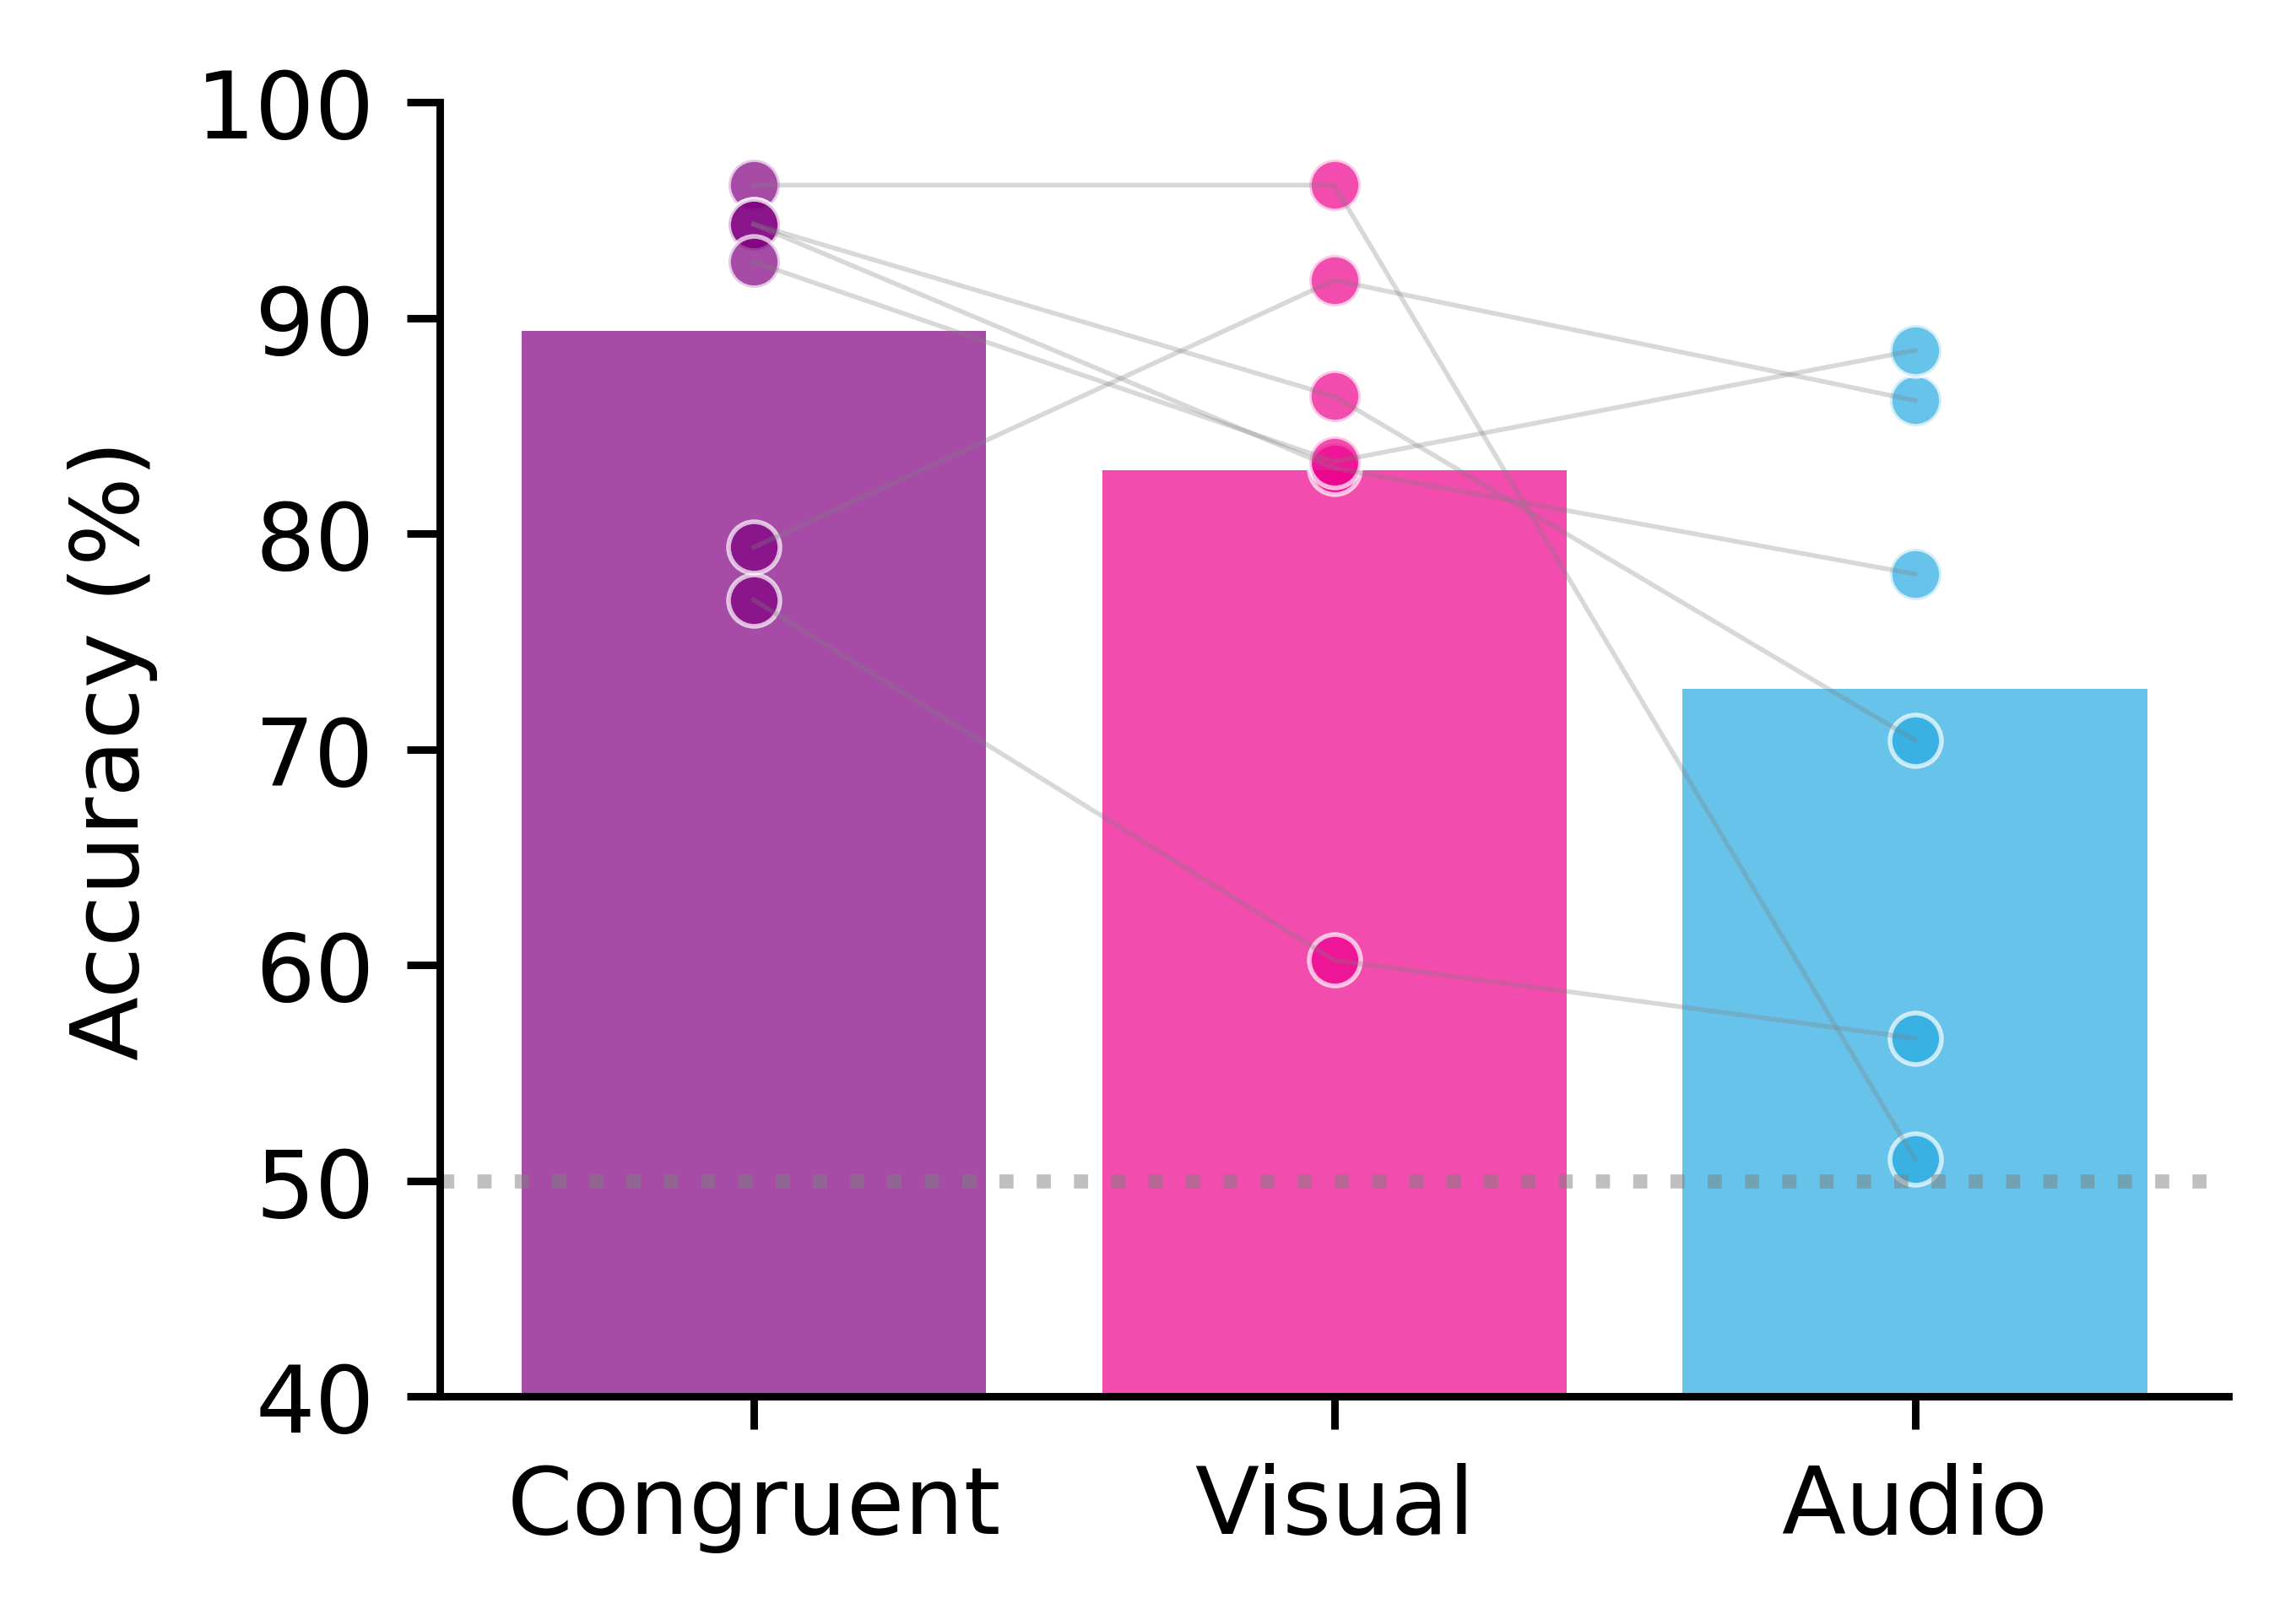

In [8]:
fig, ax = plot_context_accuracy_with_sessions(all_task_dfs['IS-2-1L'])
#plt.savefig(os.path.join(figures_dir, 'imaging_animals_performance.svg'), format='svg', bbox_inches='tight')
plt.show()

# Dynamic Choice Model - Kinematic Data

### Data Preparation

In [9]:
# Prepare data for LSTM model
def prepare_data(task_df, trialized_data):
    # Get position and velocity data (5 channels)
    X = trialized_data['X_pos']  # Shape: (n_trials, timesteps)
    Y = trialized_data['Y_pos']
    View = trialized_data['View']
    dX = trialized_data['X_velocity']
    dY = trialized_data['Y_velocity']
    
    # Stack all channels
    X_data = np.stack([X, Y, View, dX, dY], axis=2)  # Shape: (n_trials, timesteps, 5)
    
    # Get choices (already binary: 0 for left, 1 for right)
    y_data = np.array(task_df['choice'])
    
    # Remove trials with abnormal length (> 2x average)
    trial_lengths = np.array([len(trial) for trial in X])
    avg_length = np.mean(trial_lengths)
    mask = trial_lengths <= 2 * avg_length
    
    return X_data[mask], y_data[mask]

### CNN Model Framework

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Device selection for Apple Silicon (M1/M2) GPU
device = (
    torch.device("mps") 
    if torch.backends.mps.is_available() 
    else torch.device("cpu")
)
print(f"Using device: {device}")

class MovementDataset(Dataset):
    """Custom Dataset for movement data"""
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def normalize_data(all_sessions_data):
    """Normalize kinematic features across all sessions"""
    # Collect all kinematic data to compute global stats
    all_X = np.concatenate([session['X_data'] for session in all_sessions_data], axis=0)
    
    # Compute mean and std for each feature
    mean = np.mean(all_X, axis=(0, 1))  # mean across trials and timesteps
    std = np.std(all_X, axis=(0, 1))    # std across trials and timesteps
    
    # Normalize each session's data
    normalized_sessions = []
    for session in all_sessions_data:
        normalized_session = session.copy()
        normalized_session['X_data'] = (session['X_data'] - mean) / (std + 1e-8)
        normalized_sessions.append(normalized_session)
    
    return normalized_sessions, mean, std

class Dynamic_Choice_CNN(nn.Module):
    """CNN model for predicting choices at each timestep"""
    def __init__(self, n_features):
        super(Dynamic_Choice_CNN, self).__init__()
        
        # Convolutional layers with padding='same' to maintain temporal dimension
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv1d(n_features, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            # Second conv block
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            # Third conv block
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        
        # Point-wise prediction layer
        self.prediction_layer = nn.Conv1d(32, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x shape: (batch_size, timesteps, n_features)
        # Transpose for CNN: (batch_size, n_features, timesteps)
        x = x.transpose(1, 2)
        
        # Apply conv layers while maintaining temporal dimension
        x = self.conv_layers(x)
        
        # Final prediction at each timestep
        x = self.prediction_layer(x)
        x = self.sigmoid(x)
        
        # Return to (batch_size, timesteps) format
        return x.squeeze(1)

Using device: mps


### Model training functions - LOO CV 

In [11]:
def count_parameters(model):
    """
    Calculate and print the total number of trainable parameters in the model.
    
    Args:
        model: PyTorch model
        
    Returns:
        total_params: Total number of trainable parameters
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Format the number with commas for readability
    formatted_total = f"{total_params:,}"
    
    print(f"Total trainable parameters: {formatted_total}")
    
    # Print parameters by layer
    print("\nParameters by layer:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.numel():,} parameters")
            
    return total_params

In [25]:
def train_model_leave_one_session_out_CNN_with_learning_rate(all_sessions_data, device=None):
    """Training loop with normalized data"""
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Normalize data
    normalized_sessions, mean, std = normalize_data(all_sessions_data)
    predictions = []
    training_histories = []
    
    for test_session_idx in range(len(normalized_sessions)):
        test_session = normalized_sessions[test_session_idx]
        test_X = test_session['X_data']
        test_y = test_session['y_data']
        test_date = test_session['date']

        print(f"\n=== Training model {test_session_idx + 1}/{len(normalized_sessions)} ===")
        print(f"Test session date: {test_date}")
        
        # Combine other sessions for training
        train_X_list = []
        train_y_list = []
        for train_session_idx in range(len(normalized_sessions)):
            if train_session_idx != test_session_idx:
                train_X_list.append(normalized_sessions[train_session_idx]['X_data'])
                train_y_list.append(normalized_sessions[train_session_idx]['y_data'])
        
        train_X = np.concatenate(train_X_list, axis=0)
        train_y = np.concatenate(train_y_list)
        
        # Expand y to match timesteps
        train_y_expanded = np.repeat(train_y[:, np.newaxis], train_X.shape[1], axis=1)
        test_y_expanded = np.repeat(test_y[:, np.newaxis], test_X.shape[1], axis=1)
        
        # Create datasets and dataloaders
        train_dataset = MovementDataset(train_X, train_y_expanded)
        test_dataset = MovementDataset(test_X, test_y_expanded)
        
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        
        # Initialize model
        model = Dynamic_Choice_CNN(
            n_features=train_X.shape[2]
        ).to(device)
        
        # Count and print model parameters
        if test_session_idx == 0:  # Only print for the first fold to avoid repetition
            count_parameters(model)
        
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Training loop
        n_epochs = 50
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0
        
        # Initialize history dictionary to track metrics
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'learning_rate': []
        }
        
        for epoch in range(n_epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                
                # Calculate accuracy
                predicted = (outputs > 0.5).float()
                train_total += batch_y.size(0) * batch_y.size(1)
                train_correct += (predicted == batch_y).sum().item()
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    val_loss += criterion(outputs, batch_y).item()
                    
                    # Calculate accuracy
                    predicted = (outputs > 0.5).float()
                    val_total += batch_y.size(0) * batch_y.size(1)
                    val_correct += (predicted == batch_y).sum().item()
            
            # Calculate metrics
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(test_loader)
            train_accuracy = 100 * train_correct / train_total
            val_accuracy = 100 * val_correct / val_total
            
            # Get current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            
            # Save metrics
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['train_acc'].append(train_accuracy)
            history['val_acc'].append(val_accuracy)
            history['learning_rate'].append(current_lr)
            
            if (epoch + 1) % 5 == 0:
                print(f'Epoch [{epoch+1}/{n_epochs}], '
                      f'Train Loss: {avg_train_loss:.4f}, '
                      f'Val Loss: {avg_val_loss:.4f}, '
                      f'Train Acc: {train_accuracy:.2f}%, '
                      f'Val Acc: {val_accuracy:.2f}%')
            
            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                # Save best model state
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        
        # Restore best model
        model.load_state_dict(best_model_state)
        
        # Generate predictions
        model.eval()
        session_predictions = []
        test_outputs = []
        test_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X = batch_X.to(device)
                outputs = model(batch_X)
                session_predictions.append(outputs.cpu().numpy())
                test_outputs.append(outputs.cpu().numpy())
                test_targets.append(batch_y.cpu().numpy())
        
        session_predictions = np.concatenate(session_predictions, axis=0)
        predictions.append((test_date, session_predictions))
        
        # Calculate final test metrics
        test_outputs = np.concatenate(test_outputs)
        test_targets = np.concatenate(test_targets)
        test_pred = (test_outputs > 0.5).astype(float)
        
        # Calculate final test accuracy
        test_accuracy = 100 * np.mean(test_pred == test_targets)
        
        # Try to calculate AUC (may fail if only one class is present)
        try:
            from sklearn.metrics import roc_auc_score
            test_auc = roc_auc_score(test_targets.flatten(), test_outputs.flatten())
        except:
            test_auc = np.nan
            
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        if not np.isnan(test_auc):
            print(f"Test AUC: {test_auc:.4f}")
        
        # Add final test metrics to history
        history['test_accuracy'] = test_accuracy
        history['test_auc'] = test_auc
        history['test_date'] = test_date
        
        # Add history to list
        training_histories.append(history)
        
        # Clear memory
        model = model.cpu()
        
    return predictions, training_histories


In [26]:
def train_model_leave_one_session_out_CNN(all_sessions_data, device=None):
    """Training loop with normalized data without early stopping"""
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Normalize data
    normalized_sessions, mean, std = normalize_data(all_sessions_data)
    predictions = []
    training_histories = []
    
    for test_session_idx in range(len(normalized_sessions)):
        test_session = normalized_sessions[test_session_idx]
        test_X = test_session['X_data']
        test_y = test_session['y_data']
        test_date = test_session['date']

        print(f"\n=== Training model {test_session_idx + 1}/{len(normalized_sessions)} ===")
        print(f"Test session date: {test_date}")
        
        # Combine other sessions for training
        train_X_list = []
        train_y_list = []
        for train_session_idx in range(len(normalized_sessions)):
            if train_session_idx != test_session_idx:
                train_X_list.append(normalized_sessions[train_session_idx]['X_data'])
                train_y_list.append(normalized_sessions[train_session_idx]['y_data'])
        
        train_X = np.concatenate(train_X_list, axis=0)
        train_y = np.concatenate(train_y_list)
        
        # Expand y to match timesteps
        train_y_expanded = np.repeat(train_y[:, np.newaxis], train_X.shape[1], axis=1)
        test_y_expanded = np.repeat(test_y[:, np.newaxis], test_X.shape[1], axis=1)
        
        # Create datasets and dataloaders
        train_dataset = MovementDataset(train_X, train_y_expanded)
        test_dataset = MovementDataset(test_X, test_y_expanded)
        
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        
        # Initialize model
        model = Dynamic_Choice_CNN(
            n_features=train_X.shape[2]
        ).to(device)
        
        # Count and print model parameters
        if test_session_idx == 0:  # Only print for the first fold to avoid repetition
            count_parameters(model)
        
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Training loop
        n_epochs = 50
        
        # Initialize history dictionary to track metrics
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'learning_rate': []
        }
        
        for epoch in range(n_epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                
                # Calculate accuracy
                predicted = (outputs > 0.5).float()
                train_total += batch_y.size(0) * batch_y.size(1)
                train_correct += (predicted == batch_y).sum().item()
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    outputs = model(batch_X)
                    val_loss += criterion(outputs, batch_y).item()
                    
                    # Calculate accuracy
                    predicted = (outputs > 0.5).float()
                    val_total += batch_y.size(0) * batch_y.size(1)
                    val_correct += (predicted == batch_y).sum().item()
            
            # Calculate metrics
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(test_loader)
            train_accuracy = 100 * train_correct / train_total
            val_accuracy = 100 * val_correct / val_total
            
            # Get current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            
            # Save metrics
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['train_acc'].append(train_accuracy)
            history['val_acc'].append(val_accuracy)
            history['learning_rate'].append(current_lr)
            
            if (epoch + 1) % 5 == 0:
                print(f'Epoch [{epoch+1}/{n_epochs}], '
                      f'Train Loss: {avg_train_loss:.4f}, '
                      f'Val Loss: {avg_val_loss:.4f}, '
                      f'Train Acc: {train_accuracy:.2f}%, '
                      f'Val Acc: {val_accuracy:.2f}%')
        
        # Generate predictions
        model.eval()
        session_predictions = []
        test_outputs = []
        test_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X = batch_X.to(device)
                outputs = model(batch_X)
                session_predictions.append(outputs.cpu().numpy())
                test_outputs.append(outputs.cpu().numpy())
                test_targets.append(batch_y.cpu().numpy())
        
        session_predictions = np.concatenate(session_predictions, axis=0)
        predictions.append((test_date, session_predictions))
        
        # Calculate final test metrics
        test_outputs = np.concatenate(test_outputs)
        test_targets = np.concatenate(test_targets)
        test_pred = (test_outputs > 0.5).astype(float)
        
        # Calculate final test accuracy
        test_accuracy = 100 * np.mean(test_pred == test_targets)
        
        # Try to calculate AUC (may fail if only one class is present)
        try:
            from sklearn.metrics import roc_auc_score
            test_auc = roc_auc_score(test_targets.flatten(), test_outputs.flatten())
        except:
            test_auc = np.nan
            
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        if not np.isnan(test_auc):
            print(f"Test AUC: {test_auc:.4f}")
        
        # Add final test metrics to history
        history['test_accuracy'] = test_accuracy
        history['test_auc'] = test_auc
        history['test_date'] = test_date
        
        # Add history to list
        training_histories.append(history)
        
        # Clear memory
        model = model.cpu()
        
    return predictions, training_histories

### Model metrics functions

In [27]:
# To visualize training metrics for each fold:
def plot_all_folds_metrics(training_histories, metric='loss'):
    """
    Plot metrics across all leave-one-session-out folds.
    
    Args:
        training_histories: List of training history dictionaries
        metric: Metric to plot ('loss' or 'accuracy')
    """
    plt.figure(figsize=(6, 6))
    
    if metric == 'loss':
        for i, history in enumerate(training_histories):
            plt.plot(history['train_loss'], label=f"Fold {i+1} (Train)")
            plt.plot(history['val_loss'], '--', label=f"Fold {i+1} (Val)")
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Across Folds')
    elif metric == 'accuracy':
        for i, history in enumerate(training_histories):
            plt.plot(history['train_acc'], label=f"Fold {i+1} (Train)")
            plt.plot(history['val_acc'], '--', label=f"Fold {i+1} (Val)")
        plt.ylabel('Accuracy (%)')
        plt.title('Training and Validation Accuracy Across Folds')
    elif metric == 'learning_rate':
        for i, history in enumerate(training_histories):
            plt.plot(history['learning_rate'], label=f"Fold {i+1}")
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Across Folds')
    
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot final test performance across folds
def plot_test_performance(training_histories):
    """Plot test performance metrics across all folds."""
    dates = [history['test_date'] for history in training_histories]
    accuracies = [history['test_accuracy'] for history in training_histories]
    aucs = [history['test_auc'] for history in training_histories]
    
    plt.figure(figsize=(6, 6))
    x = np.arange(len(dates))
    width = 0.35
    
    plt.bar(x - width/2, accuracies, width, label='Accuracy (%)')
    #plt.bar(x + width/2, np.array(aucs) * 100, width, label='AUC (%)')
    
    plt.xlabel('Test Session Date')
    plt.ylabel('Performance (%)')
    plt.title('Model Performance Across Test Sessions')
    plt.xticks(x, dates, rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Plot learning rate over training for each fold
def plot_learning_rate(training_histories):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for i, history in enumerate(training_histories):
        ax.plot(history['learning_rate'], label=f"Fold {i+1} - {history['test_date']}")
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.set_title('Learning Rate During Training Across Folds')
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Plot training and validation loss
def plot_loss_history(training_histories):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot each fold separately
    for i, history in enumerate(training_histories):
        epochs = range(len(history['train_loss']))
        ax.plot(epochs, history['train_loss'], '-', label=f'Train Loss Fold {i+1}')
        ax.plot(epochs, history['val_loss'], '--', label=f'Val Loss Fold {i+1}')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss')
    #ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Plot training and validation accuracy
def plot_accuracy_history(training_histories):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Plot each fold separately
    for i, history in enumerate(training_histories):
        epochs = range(len(history['train_acc']))
        ax.plot(epochs, history['train_acc'], '-', label=f'Train Acc Fold {i+1}')
        ax.plot(epochs, history['val_acc'], '--', label=f'Val Acc Fold {i+1}')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Training and Validation Accuracy')
    #ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Plot final test performance across all folds
def plot_test_performance(training_histories):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    dates = [history['test_date'] for history in training_histories]
    accuracies = [history.get('test_accuracy', 0) for history in training_histories]
    
    # Try to get AUC values if they exist
    has_auc = 'test_auc' in training_histories[0]
    if has_auc:
        aucs = [history.get('test_auc', 0) * 100 for history in training_histories]  # Convert to percentage
        
        x = np.arange(len(dates))
        width = 0.35
        
        ax.bar(x - width/2, accuracies, width, label='Accuracy (%)')
        #ax.bar(x + width/2, aucs, width, label='AUC (%)')
        ax.set_xticks(x)
        ax.set_xticklabels(dates, rotation=45)
    else:
        ax.bar(range(len(dates)), accuracies, label='Accuracy (%)')
        ax.set_xticks(range(len(dates)))
        ax.set_xticklabels(dates, rotation=45)
    
    ax.set_xlabel('Test Session Date')
    ax.set_ylabel('Performance (%)')
    ax.set_title('Model Test Performance Across Sessions')
    #ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Function to visualize model predictions vs actual choices
def plot_predictions_vs_actual(predictions, all_sessions_data):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    num_sessions = len(predictions)
    cols = 3
    rows = (num_sessions + cols - 1) // cols
    
    fig, axs = plt.subplots(rows, cols, figsize=(18, 5*rows))
    # Handle the case of a single subplot
    if rows == 1 and cols == 1:
        axs = np.array([[axs]])
    elif rows == 1:
        axs = np.array([axs])
    elif cols == 1:
        axs = np.array([[ax] for ax in axs])
    
    for i, (session_date, session_preds) in enumerate(predictions):
        row_idx = i // cols
        col_idx = i % cols
        ax = axs[row_idx, col_idx]
        
        # Find corresponding session data
        actual_choices = None
        for session in all_sessions_data:
            if session['date'] == session_date:
                actual_choices = session['y_data']
                break
        
        if actual_choices is None:
            ax.set_title(f"Session {session_date} - No matching data found")
            ax.axis('off')
            continue
        
        # Flatten predictions (average across timepoints)
        avg_preds = np.mean(session_preds, axis=1)
        binary_preds = (avg_preds > 0.5).astype(float)
        
        # Calculate accuracy
        accuracy = 100 * np.mean(binary_preds == actual_choices)
        
        # Create confusion matrix
        cm = confusion_matrix(actual_choices, binary_preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'], ax=ax)
        
        ax.set_title(f"Session {session_date} - Acc: {accuracy:.1f}%")
    
    # Hide empty subplots
    for i in range(len(predictions), rows*cols):
        row_idx = i // cols
        col_idx = i % cols
        axs[row_idx, col_idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot all folds metrics on separate subplots
def plot_all_metrics_by_fold(training_histories):
    """Plot loss, accuracy, and learning rate for each fold on separate subplots"""
    n_folds = len(training_histories)
    fig, axs = plt.subplots(n_folds, 3, figsize=(18, 5*n_folds))
    
    # Handle single fold case
    if n_folds == 1:
        axs = np.array([axs])
    
    for i, history in enumerate(training_histories):
        epochs = range(len(history['train_loss']))
        
        # Plot loss
        axs[i, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss')
        axs[i, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss')
        axs[i, 0].set_title(f"Fold {i+1} - {history['test_date']} Loss")
        axs[i, 0].set_xlabel('Epoch')
        axs[i, 0].set_ylabel('Loss')
        axs[i, 0].grid(True, linestyle='--', alpha=0.7)
        axs[i, 0].legend()
        
        # Plot accuracy
        axs[i, 1].plot(epochs, history['train_acc'], 'g-', label='Train Acc')
        axs[i, 1].plot(epochs, history['val_acc'], 'm-', label='Val Acc')
        axs[i, 1].set_title(f"Fold {i+1} - {history['test_date']} Accuracy")
        axs[i, 1].set_xlabel('Epoch')
        axs[i, 1].set_ylabel('Accuracy (%)')
        axs[i, 1].grid(True, linestyle='--', alpha=0.7)
        axs[i, 1].legend()
        
        # Plot learning rate
        axs[i, 2].plot(epochs, history['learning_rate'], 'k-')
        axs[i, 2].set_title(f"Fold {i+1} - {history['test_date']} Learning Rate")
        axs[i, 2].set_xlabel('Epoch')
        axs[i, 2].set_ylabel('Learning Rate')
        axs[i, 2].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Execute all plotting functions
def visualize_all_training_results(predictions, training_histories, all_sessions_data):
    plot_loss_history(training_histories)
    plot_accuracy_history(training_histories)
    plot_test_performance(training_histories)
    #plot_predictions_vs_actual(predictions, all_sessions_data)
    # Alternative: plot_all_folds_separately(training_histories)


# Model Training / Testing

### Train the model

In [29]:
all_sessions_data = []

print("Processing sessions for each mouse:")
for mouse in mouse_list:
    print(f"\nMouse: {mouse}")
    
    # Get all unique dates for this mouse
    mouse_dates = sorted(all_task_dfs[mouse]['date'].unique())
    print(f"Dates in task_df: {mouse_dates}")
    print(f"Number of trialized sessions: {len(all_trialized_data[mouse])}")
    
    # Process each session
    for session_idx, trialized_data in enumerate(all_trialized_data[mouse]):
        # Get corresponding task_df for this session
        date = mouse_dates[session_idx]  # Use the date in order
        session_df = all_task_dfs[mouse][all_task_dfs[mouse]['date'] == date]
        
        print(f"\nProcessing session {session_idx + 1} for date {date}")
        print(f"Number of trials in behavioral data: {len(session_df)}")
        print(f"Number of trials in trialized data: {len(trialized_data)}")
        
        # Prepare data
        try:
            X_data, y_data = prepare_data(session_df, trialized_data)
            
            # Store session data
            session_info = {
                'X_data': X_data,
                'y_data': y_data,
                'date': date
            }
            all_sessions_data.append(session_info)
            print(f"Successfully added session for date {date}")
            print(f"X_data shape: {X_data.shape}, y_data shape: {y_data.shape}")
        except Exception as e:
            print(f"Error preparing data for date {date}: {e}")

print("\nFinal all_sessions_data summary:")
print(f"Total number of sessions: {len(all_sessions_data)}")
for i, session in enumerate(all_sessions_data):
    print(f"\nSession {i}:")
    print(f"Date: {session['date']}")
    print(f"X_data shape: {session['X_data'].shape}")
    print(f"y_data shape: {session['y_data'].shape}")

Processing sessions for each mouse:

Mouse: IS-2-1L
Dates in task_df: ['250314', '250320', '250401', '250402', '250404', '250408']
Number of trialized sessions: 6

Processing session 1 for date 250314
Number of trials in behavioral data: 204
Number of trials in trialized data: 5
Successfully added session for date 250314
X_data shape: (204, 200, 5), y_data shape: (204,)

Processing session 2 for date 250320
Number of trials in behavioral data: 180
Number of trials in trialized data: 5
Successfully added session for date 250320
X_data shape: (180, 200, 5), y_data shape: (180,)

Processing session 3 for date 250401
Number of trials in behavioral data: 336
Number of trials in trialized data: 5
Successfully added session for date 250401
X_data shape: (336, 200, 5), y_data shape: (336,)

Processing session 4 for date 250402
Number of trials in behavioral data: 282
Number of trials in trialized data: 5
Successfully added session for date 250402
X_data shape: (282, 200, 5), y_data shape: (282

In [20]:
all_sessions_data[0].keys()

dict_keys(['X_data', 'y_data', 'date'])

In [21]:
all_sessions_data[0]['y_data']


array([0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1])

In [30]:
predictions, training_histories = train_model_leave_one_session_out_CNN(all_sessions_data)

Using device: mps

=== Training model 1/6 ===
Test session date: 250314
Total trainable parameters: 13,185

Parameters by layer:
conv_layers.0.weight: 480 parameters
conv_layers.0.bias: 32 parameters
conv_layers.1.weight: 32 parameters
conv_layers.1.bias: 32 parameters
conv_layers.3.weight: 6,144 parameters
conv_layers.3.bias: 64 parameters
conv_layers.4.weight: 64 parameters
conv_layers.4.bias: 64 parameters
conv_layers.6.weight: 6,144 parameters
conv_layers.6.bias: 32 parameters
conv_layers.7.weight: 32 parameters
conv_layers.7.bias: 32 parameters
prediction_layer.weight: 32 parameters
prediction_layer.bias: 1 parameters
Epoch [5/50], Train Loss: 0.2990, Val Loss: 0.3016, Train Acc: 86.24%, Val Acc: 85.22%
Epoch [10/50], Train Loss: 0.2853, Val Loss: 0.2878, Train Acc: 86.73%, Val Acc: 85.98%
Epoch [15/50], Train Loss: 0.2838, Val Loss: 0.2716, Train Acc: 86.69%, Val Acc: 86.88%
Epoch [20/50], Train Loss: 0.2747, Val Loss: 0.2757, Train Acc: 87.65%, Val Acc: 85.87%
Epoch [25/50], Tra

### Visualize model training / testing metrics

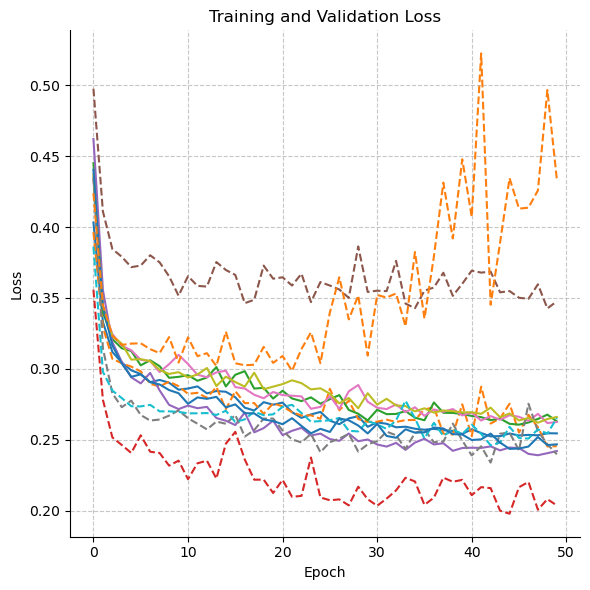

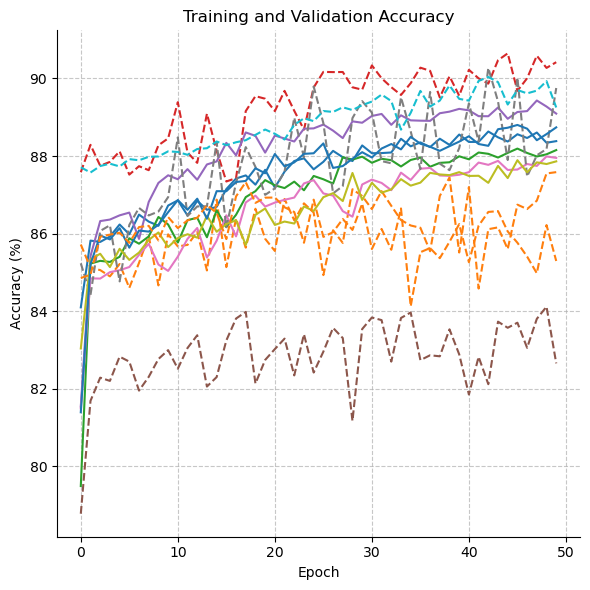

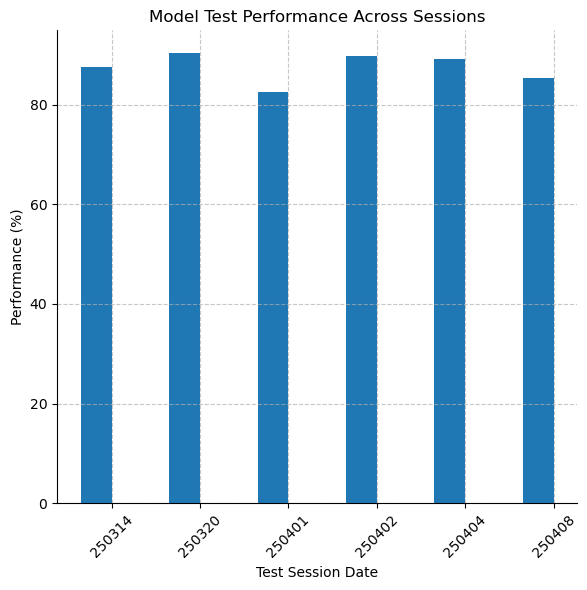

In [35]:
# After training, call:
visualize_all_training_results(predictions, training_histories, all_sessions_data)

# Make predictions from trained model

### Functions 

In [45]:
def convert_predictions_to_array(predictions_list):
    """
    Convert list of (session_date, predictions) tuples to a single numpy array.
    
    Args:
        predictions_list: List of tuples (session_date, predictions) from model
    
    Returns:
        numpy.ndarray: Concatenated predictions array
    """
    all_predictions = []
    for _, session_pred in predictions_list:
        if isinstance(session_pred, np.ndarray):
            if session_pred.ndim == 3:
                session_pred = session_pred.squeeze()
            all_predictions.append(session_pred)
    
    if all_predictions:
        return np.concatenate(all_predictions, axis=0)
    else:
        raise ValueError("No valid predictions found in the list")
    
def calculate_latency_to_choice(predictions_input, all_choices, threshold=0.95, min_frames=5):
    """
    Calculate latency to choice for each trial based on when model prediction
    crosses threshold and stays above/below for specified number of frames.
    
    Args:
        predictions_input: Either a numpy array of predictions or list of (date, predictions) tuples
        all_choices: Array of actual choices (0 or 1)
        threshold: Confidence threshold for choice (default 0.95)
        min_frames: Minimum number of consecutive frames required to be above/below threshold (default 3)
    
    Returns:
        numpy.ndarray: Array of latencies (as percentage of trial duration)
                      -1 indicates threshold never crossed stably
    """
    # Handle input format
    if isinstance(predictions_input, list):
        # Convert from list of tuples format
        all_predictions = []
        for _, session_pred in predictions_input:
            if session_pred.ndim == 3:
                session_pred = session_pred.squeeze()
            all_predictions.append(session_pred)
        predictions = np.concatenate(all_predictions, axis=0)
    else:
        # Input is already a numpy array
        predictions = predictions_input
        if predictions.ndim == 3:
            predictions = predictions.squeeze()
    
    n_trials = len(predictions)
    trial_length = predictions.shape[1]  # Number of timepoints per trial
    latencies = np.full(n_trials, -1.)  # Initialize all latencies to -1
    
    # Calculate latency for each trial
    for i in range(n_trials):
        pred = predictions[i]
        
        if all_choices[i] == 1:  # Right choice
            # Create binary array where 1 indicates prediction > threshold
            above_threshold = pred > threshold
            
            # Find first valid crossing point
            for t in range(trial_length - min_frames + 1):
                if np.all(above_threshold[t:t+min_frames]):
                    latencies[i] = (t / trial_length) * 100
                    break
                
        else:  # Left choice
            # Create binary array where 1 indicates prediction < (1-threshold)
            below_threshold = pred < (1-threshold)
            
            # Find first valid crossing point
            for t in range(trial_length - min_frames + 1):
                if np.all(below_threshold[t:t+min_frames]):
                    latencies[i] = (t / trial_length) * 100
                    break
            
    return latencies

def plot_latency_distribution(latencies, title="Latency to Choice Distribution"):
    """
    Plot the distribution of latencies to choice.
    
    Args:
        latencies: Array of latencies (as percentage of trial duration)
        title: Plot title
    """
    # Filter out trials where threshold was never crossed (-1)
    valid_latencies = latencies[latencies >= 0]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot histogram
    bins = np.linspace(0, 100, 30)  # Bins from 0% to 100% of trial
    ax.hist(valid_latencies, bins=bins, color='blue', alpha=0.7)
    
    # Plot statistics
    mean_latency = np.mean(valid_latencies)
    median_latency = np.median(valid_latencies)
    
    ax.axvline(mean_latency, color='red', linestyle='--', label=f'Mean: {mean_latency:.1f}%')
    ax.axvline(median_latency, color='green', linestyle='-.', label=f'Median: {median_latency:.1f}%')
    
    # Add text with summary statistics
    stats_text = f"""
    Valid trials: {len(valid_latencies)}/{len(latencies)} ({100*len(valid_latencies)/len(latencies):.1f}%)
    Mean latency: {mean_latency:.1f}%
    Median latency: {median_latency:.1f}%
    Std deviation: {np.std(valid_latencies):.1f}%
    """
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Latency (% of trial duration)')
    ax.set_ylabel('Number of trials')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return valid_latencies

def compare_latency_by_condition(predictions_list, all_choices_list, condition_names, 
                                threshold=0.95, min_frames=3):
    """
    Compare latency distributions across different experimental conditions.
    
    Args:
        predictions_list: List of prediction arrays for different conditions
        all_choices_list: List of choice arrays for different conditions
        condition_names: List of names for the conditions
        threshold: Confidence threshold for choice
        min_frames: Minimum number of consecutive frames required
        
    Returns:
        dict: Dictionary with latency statistics for each condition
    """
    all_latencies = []
    stats = {}
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate and plot latencies for each condition
    for i, (predictions, choices, condition) in enumerate(zip(predictions_list, all_choices_list, condition_names)):
        latencies = calculate_latency_to_choice(predictions, choices, threshold, min_frames)
        valid_latencies = latencies[latencies >= 0]
        all_latencies.append(valid_latencies)
        
        # Plot histogram
        bins = np.linspace(0, 100, 25)
        ax.hist(valid_latencies, bins=bins, alpha=0.6, label=condition)
        
        # Calculate statistics
        mean_lat = np.mean(valid_latencies)
        median_lat = np.median(valid_latencies)
        std_lat = np.std(valid_latencies)
        valid_percent = 100 * len(valid_latencies) / len(latencies)
        
        stats[condition] = {
            'mean': mean_lat,
            'median': median_lat,
            'std': std_lat,
            'valid_percent': valid_percent
        }
        
        # Add vertical line for mean
        ax.axvline(mean_lat, color=f'C{i}', linestyle='--')
    
    # Add statistical comparison if more than one condition
    if len(all_latencies) > 1:
        from scipy import stats as scipy_stats
        
        # Perform t-test
        t_stat, p_value = scipy_stats.ttest_ind(all_latencies[0], all_latencies[1])
        
        # Add p-value to plot
        if p_value < 0.001:
            p_text = "p < 0.001"
        else:
            p_text = f"p = {p_value:.3f}"
            
        plt.figtext(0.5, 0.01, f"T-test: {p_text}", 
                   ha='center', fontsize=12, 
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.1))
    
    ax.set_xlabel('Latency (% of trial duration)')
    ax.set_ylabel('Number of trials')
    ax.set_title('Decision Latency by Condition')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return stats

### Predictions

In [42]:
# Get corresponding choices from the task dataframe
all_choices = []
for mouse in mouse_list:
    all_choices.extend(all_task_dfs[mouse]['choice'].values)
all_choices = np.array(all_choices)

In [43]:
# Now you can use this before any function that expects a numpy array:
predictions_array = convert_predictions_to_array(predictions)

# Then use predictions_array in your function calls
if predictions_array.ndim == 3:
    predictions_array = predictions_array.squeeze()

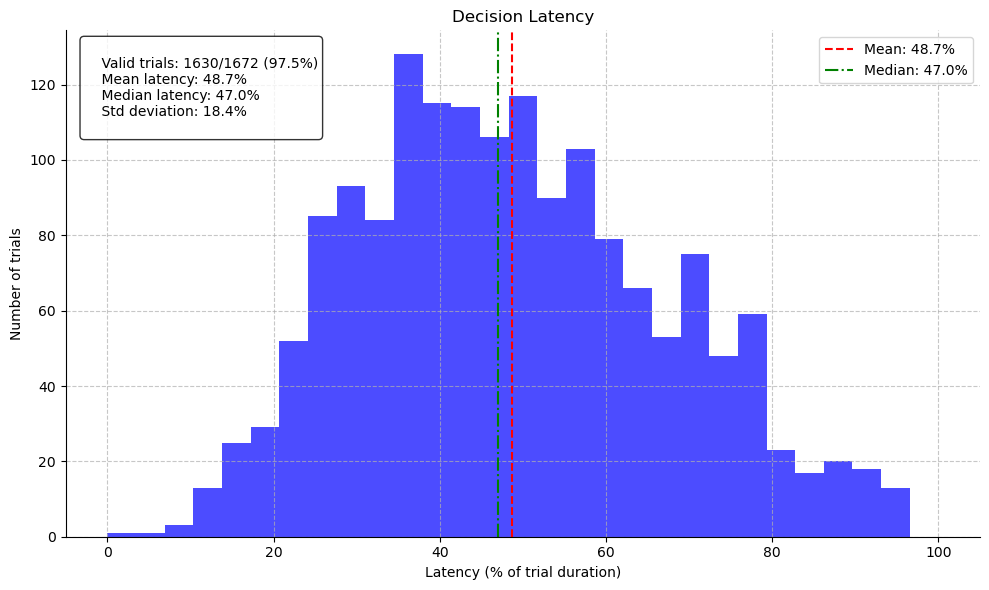

In [57]:
# Calculate latencies with min_frames constraint
latencies = calculate_latency_to_choice(predictions, all_choices, threshold=0.95, min_frames=10)

# Plot the distribution
valid_latencies = plot_latency_distribution(latencies, title="Decision Latency")

In [58]:
# Calculate latency to choice
#latencies = calculate_latency_to_choice(predictions_array, all_choices)

### Plot predictions

In [59]:
def plot_mean_latency_by_context(task_df, latencies):
    """
    Plot mean latency for each context with error bars and individual session data points.
    
    Args:
        task_df (pd.DataFrame): DataFrame containing trial information including contexts
        latencies (np.array): Array of latency values for each trial
        
    Returns:
        tuple: (fig, ax) matplotlib figure and axes objects
    """
    fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=800)
    
    context_names = ['Congruent', 'Visual', 'Audio']
    context_colors = {0: 'purple', 1: '#EC008C', 2: '#27AAE1'}
    
    # Calculate overall mean latency for each context
    means = []
    sems = []
    
    for ctx in [0, 1, 2]:
        # Get latencies for this context
        ctx_mask = task_df['context'] == ctx
        ctx_latencies = latencies[ctx_mask]
        valid_latencies = ctx_latencies[ctx_latencies >= 0]  # Exclude invalid (-1) latencies
        
        mean_lat = np.mean(valid_latencies) if len(valid_latencies) > 0 else np.nan
        sem_lat = scipy.stats.sem(valid_latencies) if len(valid_latencies) > 0 else np.nan
        
        means.append(mean_lat)
        sems.append(sem_lat)
    
    # Plot bars
    x_positions = np.arange(len(context_names))
    ax.bar(x_positions, means, 
           color=[context_colors[i] for i in range(3)],
           alpha=0.3)  # Reduced alpha to make individual points more visible
    
    # Add error bars
    ax.errorbar(x_positions, means, yerr=sems,
               fmt='none', color='black', capsize=5)
    
    # Plot individual session data points
    for ctx in [0, 1, 2]:
        # Calculate mean latency for each session
        for session_date in task_df['date'].unique():
            session_mask = (task_df['date'] == session_date) & (task_df['context'] == ctx)
            session_latencies = latencies[session_mask]
            valid_latencies = session_latencies[session_latencies >= 0]
            
            if len(valid_latencies) > 0:
                session_mean = np.mean(valid_latencies)
                # Add jitter to x-position to avoid overlapping points
                jitter = np.random.normal(0, 0.05)
                ax.scatter(x_positions[ctx] + jitter, session_mean,
                          color=context_colors[ctx],
                          s=50,  # Point size
                          alpha=0.7,
                          edgecolor='white',
                          linewidth=0.5)
    
    # Customize plot
    ax.set_xticks(x_positions)
    ax.set_xticklabels(context_names)
    ax.set_ylabel('Latency to choice\n(% of maze)')
    ax.set_ylim(20, 85)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig, ax

def plot_example_trajectories_predictions(predictions, all_choices, all_task_dfs, mouse_list, n_examples=1):
    """
    Plot example model prediction trajectories for each context, showing one left and one right choice.
    
    Args:
        predictions (np.array): Model predictions over time (n_trials, n_timepoints)
        all_choices (np.array): Actual choices made (n_trials)
        all_task_dfs (dict): Dictionary of task DataFrames
        mouse_list (list): List of mouse IDs
        n_examples (int): Number of example trajectories to plot per choice per context
        
    Returns:
        tuple: (fig, axs) matplotlib figure and axes objects
    """
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=800)
    
    context_names = ['Congruent', 'Visual', 'Audio']
    context_colors = {0: 'purple', 1: '#EC008C', 2: '#27AAE1'}
    
    # Get task_df
    task_df = pd.concat([all_task_dfs[mouse] for mouse in mouse_list], ignore_index=True)
    
    # Create maze position array (0-100%)
    maze_positions = np.linspace(0, 100, predictions.shape[1])
    
    for ctx_idx, ctx in enumerate([0, 1, 2]):
        ax = axs[ctx_idx]
        
        # Get trials for this context
        ctx_mask = task_df['context'] == ctx
        ctx_trials = np.where(ctx_mask)[0]
        
        # Get left and right choice trials
        left_trials = ctx_trials[all_choices[ctx_trials] == 0]
        right_trials = ctx_trials[all_choices[ctx_trials] == 1]
        
        # Select random correct trials for each choice
        correct_left = left_trials[task_df.iloc[left_trials]['outcome'] == 1]
        correct_right = right_trials[task_df.iloc[right_trials]['outcome'] == 1]
        
        # Randomly select trials
        np.random.seed(45)  # For reproducibility
        selected_left = np.random.choice(correct_left, size=min(n_examples, len(correct_left)), replace=False)
        selected_right = np.random.choice(correct_right, size=min(n_examples, len(correct_right)), replace=False)
        
        # Plot trajectories
        for trial_idx in selected_left:
            ax.plot(maze_positions, predictions[trial_idx], 
                   color=context_colors[ctx], 
                   alpha=0.7,
                   linestyle='-',
                   label='Left choice' if trial_idx == selected_left[0] else '')
            
        for trial_idx in selected_right:
            ax.plot(maze_positions, predictions[trial_idx], 
                   color=context_colors[ctx], 
                   alpha=0.7,
                   linestyle='--',
                   label='Right choice' if trial_idx == selected_right[0] else '')
        
        # Add horizontal line at 0.5
        ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
        
        # Customize plot
        ax.set_title(context_names[ctx_idx])
        ax.set_xlabel('% of maze')
        ax.set_ylabel('P(Right)' if ctx_idx == 0 else '')
        
        # Set axis limits
        ax.set_ylim(-0.1, 1.1)
        ax.set_xlim(0, 100)
        
        # Remove spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.axhline(y=0.1, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(y=0.9, color='gray', linestyle=':', alpha=0.5)

        # Add legend for first plot only
        if ctx_idx == 0:
            ax.legend(frameon=False)
    
    plt.tight_layout()
    return fig, axs

In [60]:
def plot_example_trajectories_predictions_with_latency(predictions, all_choices, all_task_dfs, mouse_list, 
                                                      threshold=0.9, min_frames=3, n_examples=1):
    """
    Plot example model prediction trajectories for each context with markers showing 
    when the prediction crosses the threshold and remains stable.
    
    Args:
        predictions: Model predictions over time - either a numpy array of shape (n_trials, n_timepoints)
                    or a list of tuples (date, predictions)
        all_choices (np.array): Actual choices made (n_trials)
        all_task_dfs (dict): Dictionary of task DataFrames
        mouse_list (list): List of mouse IDs
        threshold (float): Confidence threshold for choice (default 0.9)
        min_frames (int): Minimum number of consecutive frames required (default 3)
        n_examples (int): Number of example trajectories to plot per choice per context
        
    Returns:
        tuple: (fig, axs) matplotlib figure and axes objects
    """
    # Convert predictions if provided as a list of tuples
    if isinstance(predictions, list):
        # Extract predictions from the list of tuples
        all_pred_arrays = []
        for _, session_pred in predictions:
            if isinstance(session_pred, np.ndarray):
                if session_pred.ndim == 3:
                    session_pred = session_pred.squeeze()
                all_pred_arrays.append(session_pred)
        
        # Concatenate all prediction arrays
        predictions_array = np.concatenate(all_pred_arrays, axis=0)
    else:
        # Already a numpy array
        predictions_array = predictions
        if predictions_array.ndim == 3:
            predictions_array = predictions_array.squeeze()
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=800)
    
    context_names = ['Congruent', 'Visual', 'Audio']
    context_colors = {0: 'purple', 1: '#EC008C', 2: '#27AAE1'}
    
    # Get task_df
    task_df = pd.concat([all_task_dfs[mouse] for mouse in mouse_list], ignore_index=True)
    
    # Create maze position array (0-100%)
    n_timepoints = predictions_array.shape[1]
    maze_positions = np.linspace(0, 100, n_timepoints)
    
    for ctx_idx, ctx in enumerate([0, 1, 2]):
        ax = axs[ctx_idx]
        
        # Get trials for this context
        ctx_mask = task_df['context'] == ctx
        ctx_trials = np.where(ctx_mask)[0]
        
        # Get left and right choice trials
        left_trials = ctx_trials[all_choices[ctx_trials] == 0]
        right_trials = ctx_trials[all_choices[ctx_trials] == 1]
        
        # Select random correct trials for each choice
        correct_left = left_trials[task_df.iloc[left_trials]['outcome'] == 1]
        correct_right = right_trials[task_df.iloc[right_trials]['outcome'] == 1]
        
        # Randomly select trials
        np.random.seed(45)  # For reproducibility
        selected_left = np.random.choice(correct_left, size=min(n_examples, len(correct_left)), replace=False)
        selected_right = np.random.choice(correct_right, size=min(n_examples, len(correct_right)), replace=False)
        
        # Plot trajectories with latency markers
        # For left choices
        for trial_idx in selected_left:
            # Plot the trajectory
            ax.plot(maze_positions, predictions_array[trial_idx], 
                   color=context_colors[ctx], 
                   alpha=0.7,
                   linestyle='-',
                   label='Left choice' if trial_idx == selected_left[0] else '')
            
            # Calculate latency index (frame where decision threshold is crossed)
            latency_index = -1
            pred = predictions_array[trial_idx]
            
            # For left choice, find when prediction < (1-threshold) for min_frames consecutive frames
            for t in range(n_timepoints - min_frames + 1):
                if np.all(pred[t:t+min_frames] < (1-threshold)):
                    latency_index = t
                    break
            
            # If a valid latency was found, mark it on the plot
            if latency_index >= 0:
                latency_pos = maze_positions[latency_index]
                latency_pred = pred[latency_index]
                ax.plot(latency_pos, latency_pred, 'o', color='black', 
                        markerfacecolor=context_colors[ctx], markersize=8, alpha=0.8)
                
                # Add a vertical line at the latency point
                ax.axvline(x=latency_pos, color=context_colors[ctx], linestyle=':', alpha=0.4)
            
        # For right choices
        for trial_idx in selected_right:
            # Plot the trajectory
            ax.plot(maze_positions, predictions_array[trial_idx], 
                   color=context_colors[ctx], 
                   alpha=0.7,
                   linestyle='--',
                   label='Right choice' if trial_idx == selected_right[0] else '')
            
            # Calculate latency index (frame where decision threshold is crossed)
            latency_index = -1
            pred = predictions_array[trial_idx]
            
            # For right choice, find when prediction > threshold for min_frames consecutive frames
            for t in range(n_timepoints - min_frames + 1):
                if np.all(pred[t:t+min_frames] > threshold):
                    latency_index = t
                    break
            
            # If a valid latency was found, mark it on the plot
            if latency_index >= 0:
                latency_pos = maze_positions[latency_index]
                latency_pred = pred[latency_index]
                ax.plot(latency_pos, latency_pred, 'o', color='black', 
                        markerfacecolor=context_colors[ctx], markersize=8, alpha=0.8)
                
                # Add a vertical line at the latency point
                ax.axvline(x=latency_pos, color=context_colors[ctx], linestyle=':', alpha=0.4)
        
        # Add horizontal lines at thresholds
        ax.axhline(y=0.5, color='gray', linestyle='-', alpha=0.3)
        ax.axhline(y=threshold, color='gray', linestyle=':', alpha=0.5)
        ax.axhline(y=1-threshold, color='gray', linestyle=':', alpha=0.5)
        
        # Add shaded region for decision thresholds
        ax.axhspan(threshold, 1.1, color='red', alpha=0.1)  # Right choice region
        ax.axhspan(-0.1, 1-threshold, color='blue', alpha=0.1)  # Left choice region
        
        # Customize plot
        ax.set_title(f"{context_names[ctx_idx]} Context")
        ax.set_xlabel('Position in Maze (%)')
        ax.set_ylabel('P(Right)' if ctx_idx == 0 else '')
        
        # Set axis limits
        ax.set_ylim(-0.1, 1.1)
        ax.set_xlim(0, 100)
        
        # Remove spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Add legend for first plot only
        if ctx_idx == 0:
            ax.legend(frameon=False)
    
    # Add a general title with threshold information
    plt.suptitle(f"Model Prediction Trajectories with Decision Points (Threshold={threshold}, Min Frames={min_frames})", 
                 fontsize=14, y=1.05)
    
    plt.tight_layout()
    return fig, axs

def plot_latency_distribution_by_context(predictions, all_choices, all_task_dfs, mouse_list, 
                                        threshold=0.9, min_frames=3):
    """
    Plot latency distributions for each context.
    
    Args:
        predictions: Model predictions over time - either a numpy array of shape (n_trials, n_timepoints)
                     or a list of tuples (date, predictions)
        all_choices (np.array): Actual choices made (n_trials)
        all_task_dfs (dict): Dictionary of task DataFrames
        mouse_list (list): List of mouse IDs
        threshold (float): Confidence threshold for choice
        min_frames (int): Minimum number of consecutive frames required
    """
    # Convert predictions if provided as a list of tuples
    if isinstance(predictions, list):
        # Extract predictions from the list of tuples
        all_pred_arrays = []
        for _, session_pred in predictions:
            if isinstance(session_pred, np.ndarray):
                if session_pred.ndim == 3:
                    session_pred = session_pred.squeeze()
                all_pred_arrays.append(session_pred)
        
        # Concatenate all prediction arrays
        predictions_array = np.concatenate(all_pred_arrays, axis=0)
    else:
        # Already a numpy array
        predictions_array = predictions
        if predictions_array.ndim == 3:
            predictions_array = predictions_array.squeeze()
    
    # Get task_df
    task_df = pd.concat([all_task_dfs[mouse] for mouse in mouse_list], ignore_index=True)
    
    # Create figure
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    context_names = ['Congruent', 'Visual', 'Audio']
    context_colors = {0: 'purple', 1: '#EC008C', 2: '#27AAE1'}
    
    all_latencies = {}
    
    for ctx_idx, ctx in enumerate([0, 1, 2]):
        ax = axs[ctx_idx]
        
        # Get trials for this context
        ctx_mask = task_df['context'] == ctx
        ctx_trials = np.where(ctx_mask)[0]
        
        # Check if we have any trials for this context
        if len(ctx_trials) == 0:
            ax.text(0.5, 0.5, f"No trials for {context_names[ctx_idx]} context", 
                    ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{context_names[ctx_idx]} Context")
            continue
        
        # Calculate latencies for this context
        ctx_predictions = predictions_array[ctx_trials]
        ctx_choices = all_choices[ctx_trials]
        
        latencies = calculate_latency_to_choice(ctx_predictions, ctx_choices, 
                                              threshold=threshold, min_frames=min_frames)
        
        all_latencies[context_names[ctx_idx]] = latencies
        
        # Filter out trials where threshold was never crossed (-1)
        valid_latencies = latencies[latencies >= 0]
        
        # Plot histogram
        bins = np.linspace(0, 100, 30)  # Bins from 0% to 100% of trial
        ax.hist(valid_latencies, bins=bins, color=context_colors[ctx], alpha=0.7)
        
        # Plot statistics (only if we have valid latencies)
        if len(valid_latencies) > 0:
            mean_latency = np.mean(valid_latencies)
            median_latency = np.median(valid_latencies)
            
            ax.axvline(mean_latency, color='red', linestyle='--', label=f'Mean: {mean_latency:.1f}%')
            ax.axvline(median_latency, color='green', linestyle='-.', label=f'Median: {median_latency:.1f}%')
            
            # Add text with summary statistics
            valid_ratio = len(valid_latencies)/len(latencies)
            stats_text = f"""
            Valid: {len(valid_latencies)}/{len(latencies)} ({100*valid_ratio:.1f}%)
            Mean: {mean_latency:.1f}%
            Median: {median_latency:.1f}%
            Std: {np.std(valid_latencies):.1f}%
            """
        else:
            stats_text = "No valid latencies found"
            
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_xlabel('Latency (% of trial)')
        ax.set_ylabel('Number of trials' if ctx_idx == 0 else '')
        ax.set_title(f"{context_names[ctx_idx]} Context")
        if len(valid_latencies) > 0:
            ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.suptitle(f"Latency to Choice by Context (Threshold={threshold}, Min Frames={min_frames})", 
                fontsize=14, y=1.05)
    plt.tight_layout()
    
    return fig, axs, all_latencies

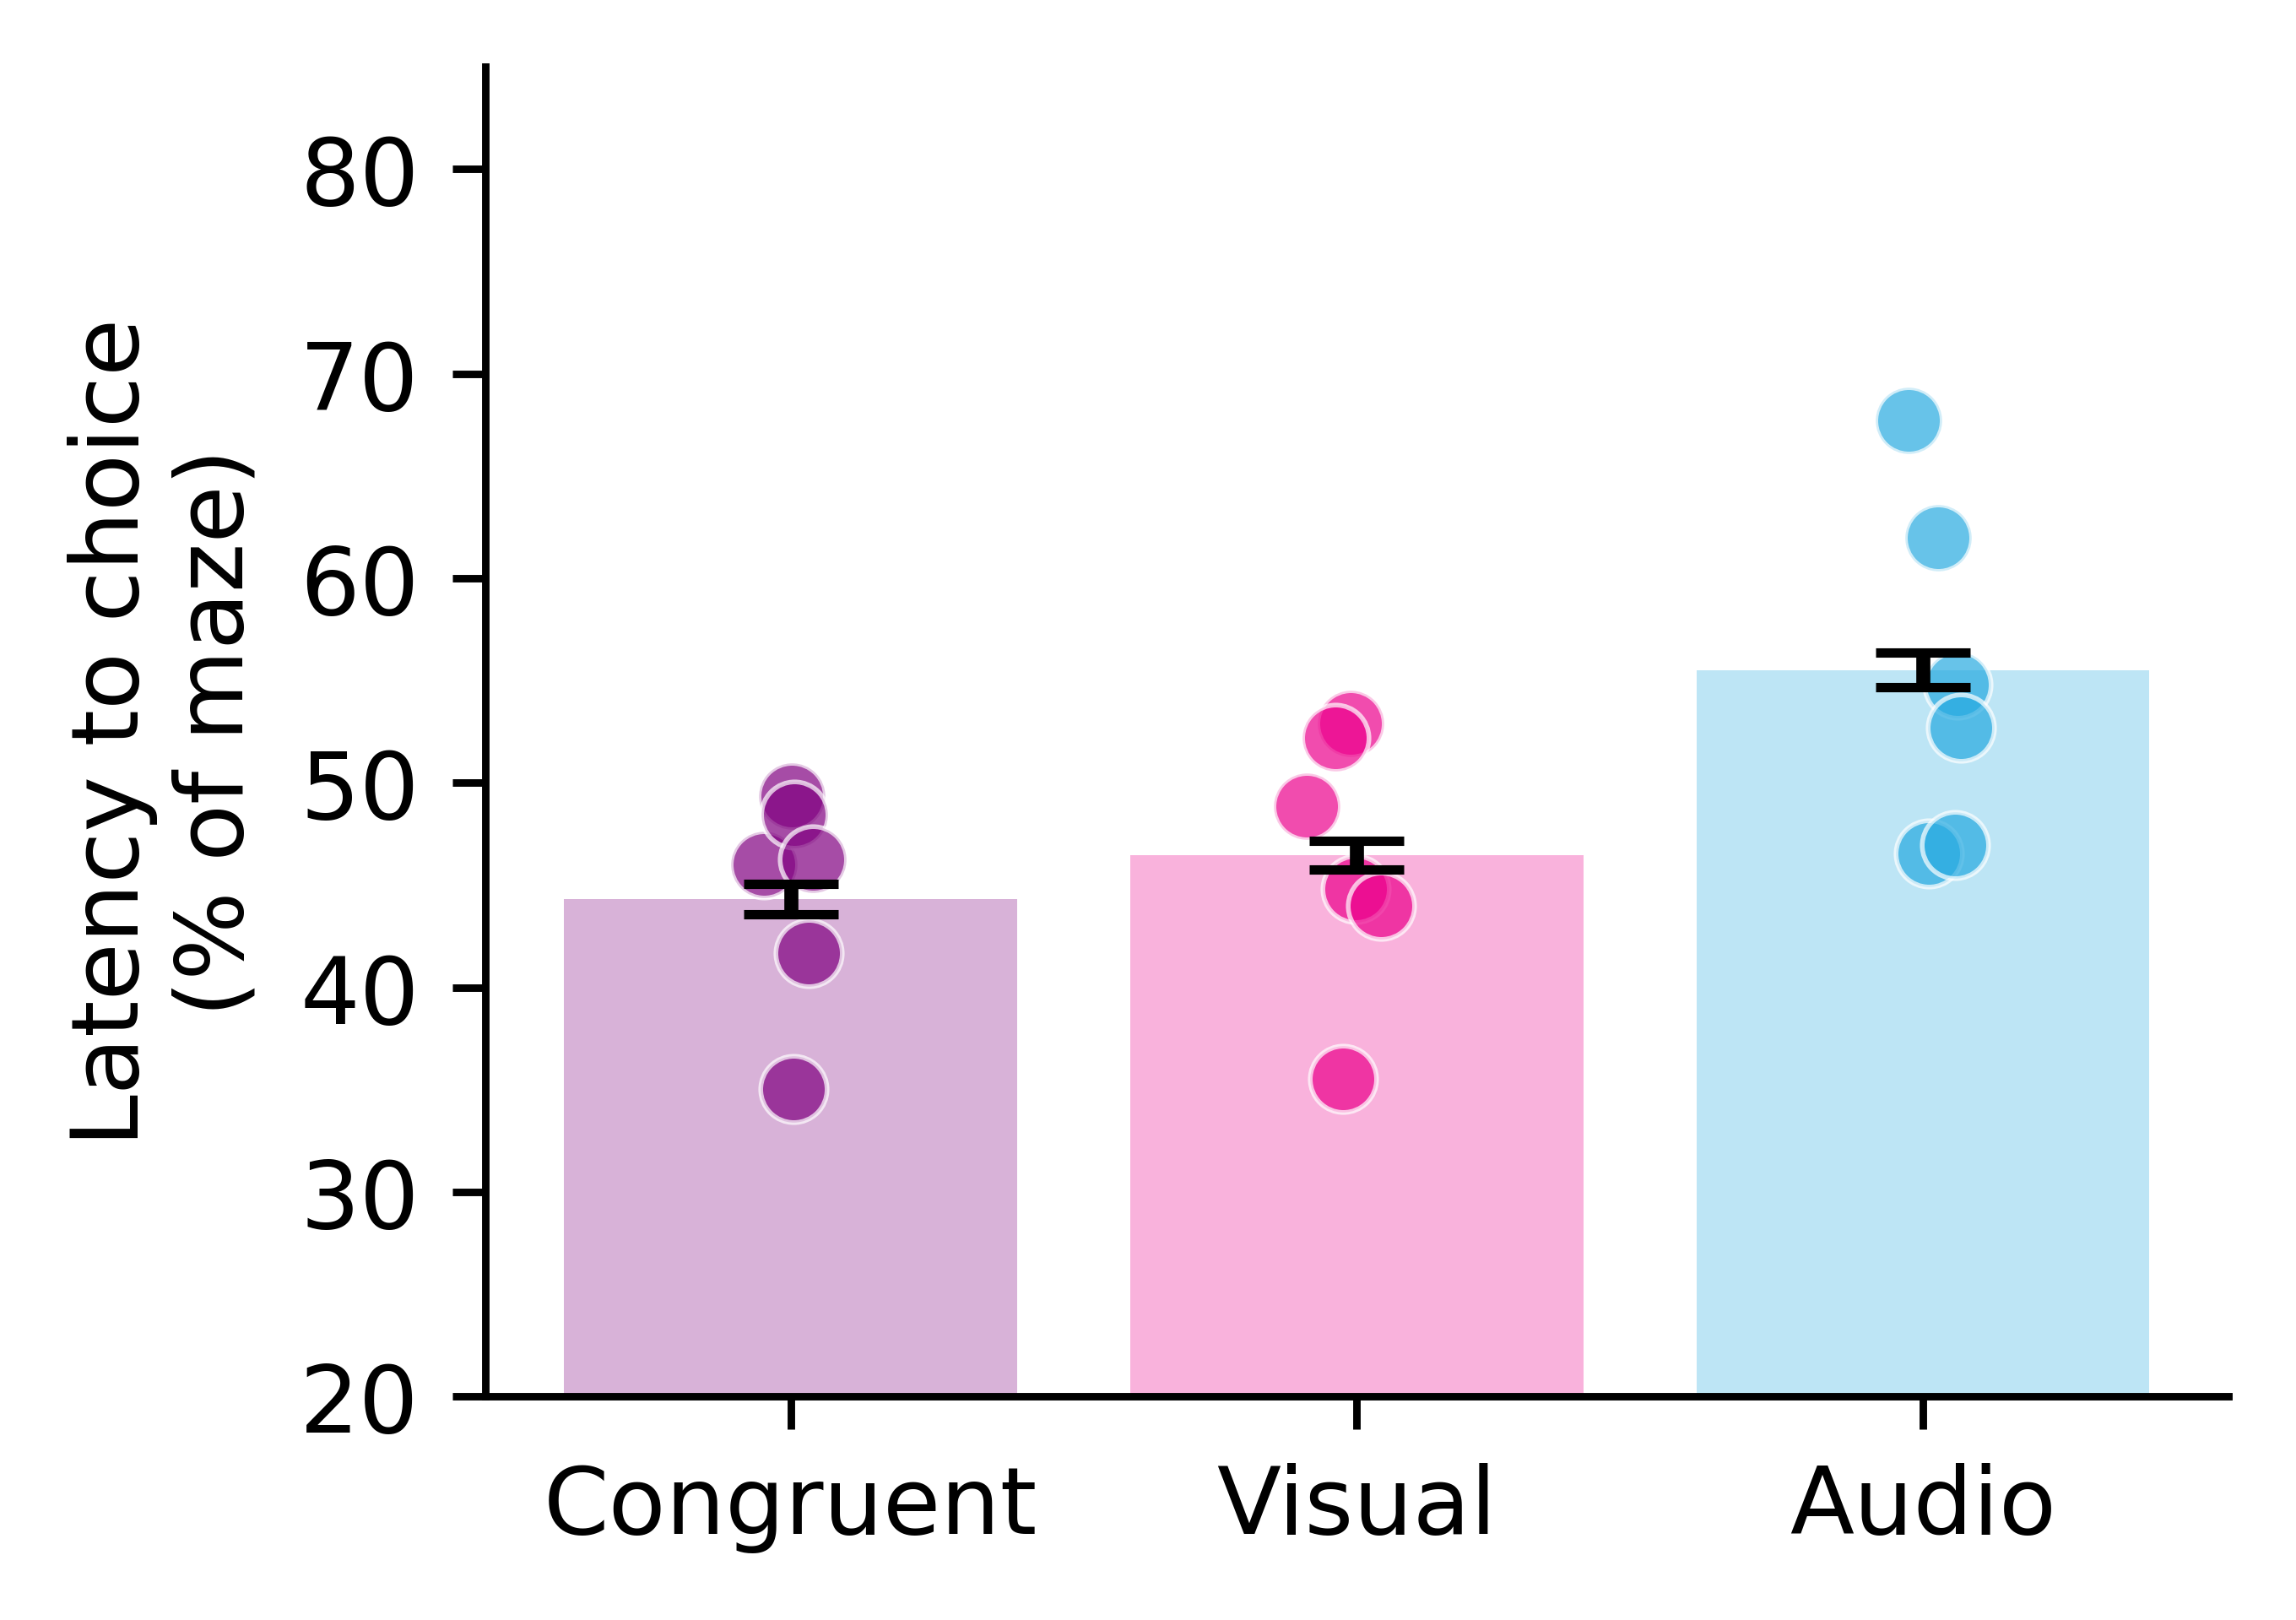

In [61]:
fig, ax = plot_mean_latency_by_context(all_task_dfs['IS-2-1L'], latencies)
plt.show()

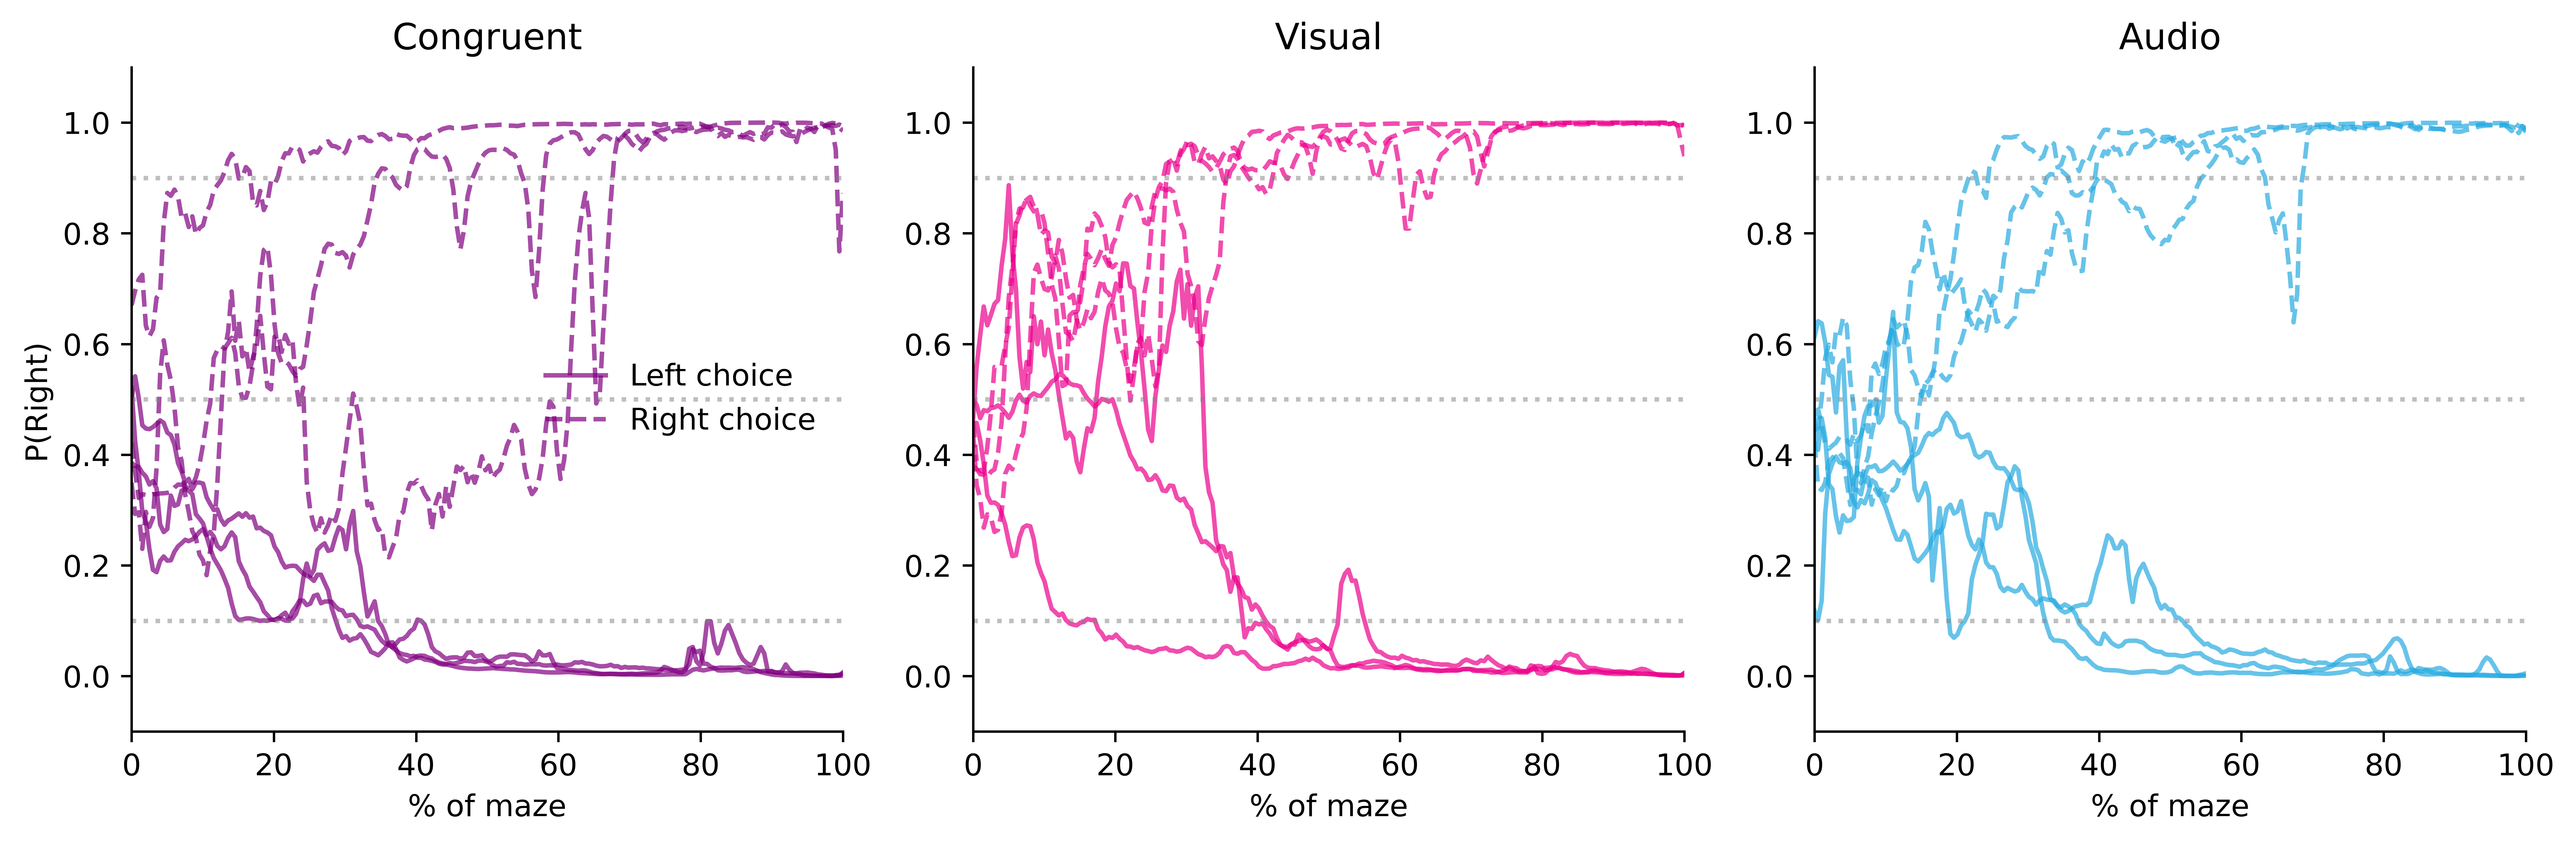

In [62]:
fig, axs = plot_example_trajectories_predictions(predictions_array, all_choices, all_task_dfs, mouse_list, n_examples=3)
plt.show()

Congruent context - Mean latency: 44.32%, Valid decisions: 531/537 (98.9%)
Visual context - Mean latency: 46.46%, Valid decisions: 567/569 (99.6%)
Audio context - Mean latency: 55.50%, Valid decisions: 532/566 (94.0%)


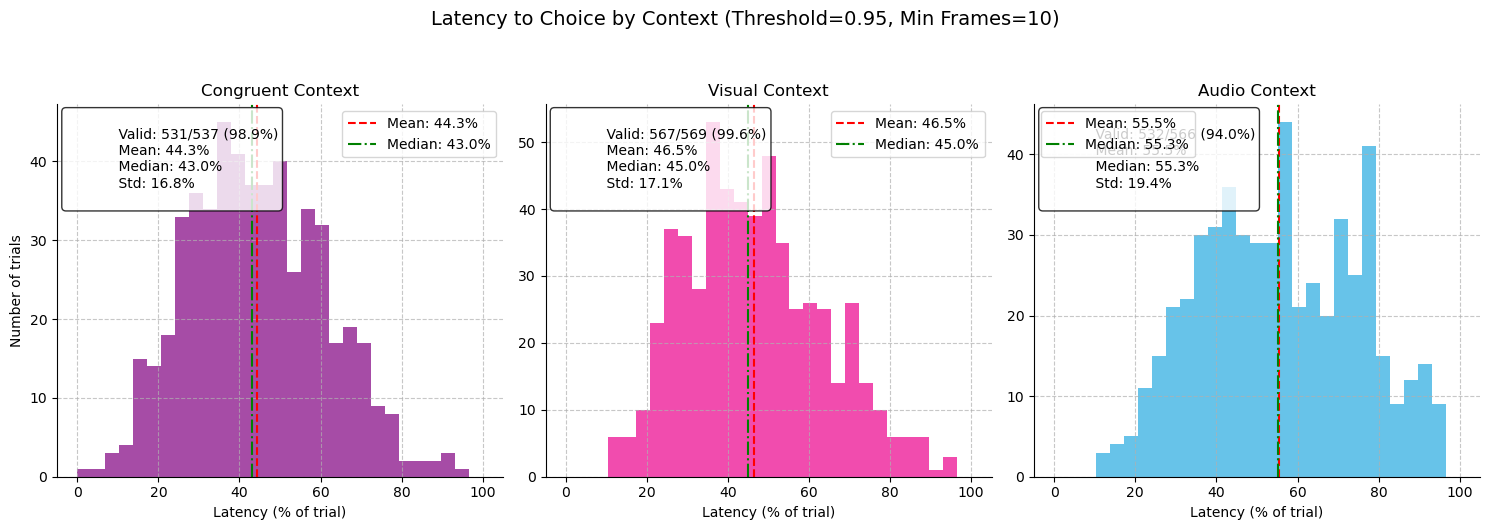

In [64]:
# Assuming predictions is your list of tuples (date, predictions)
fig, axs = plot_example_trajectories_predictions_with_latency(
    predictions, all_choices, all_task_dfs, mouse_list, 
    threshold=0.95, min_frames=10, n_examples=3
)

fig, axs, context_latencies = plot_latency_distribution_by_context(
    predictions, all_choices, all_task_dfs, mouse_list,
    threshold=0.95, min_frames=10
)

# You can also calculate and print mean latencies for each context
for context, latencies in context_latencies.items():
    valid_latencies = latencies[latencies >= 0]
    print(f"{context} context - Mean latency: {np.mean(valid_latencies):.2f}%, "
          f"Valid decisions: {len(valid_latencies)}/{len(latencies)} "
          f"({100*len(valid_latencies)/len(latencies):.1f}%)")